In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from deformtools.tools import da_median, get_ci, get_percentiles, alphabet

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

In [420]:
dat = xr.open_mfdataset('../data/clusters/combinations_lt_10_*.nc',concat_dim='clusters',)

In [659]:
maspect = dat.aspect.rolling(time=4, center=True).median().median('clusters').chunk({'time':1}).compute()
mlength = dat.length.rolling(time=4, center=True).median().median('clusters').chunk({'time':1}).compute()


mvort = dat.vort.rolling(time=4, center=True).median().median('clusters').chunk({'time':1}).compute()
mdiv = dat.div.rolling(time=4, center=True).median().median('clusters').chunk({'time':1}).compute()
mstrain = dat.strain.rolling(time=4, center=True).median().median('clusters').chunk({'time':1}).compute()

ff = gsw.f(17.22)
deriv = -mvort.pipe(lambda x: x*ff).differentiate('time',datetime_unit='s')/(ff+mvort*ff)

In [4]:
??get_percentiles

Signature: get_percentiles(array)
Docstring: <no docstring>
Source:   
def get_percentiles(array):
    alpha = 0.95
    return np.nanpercentile(array, 100 * (1 - alpha) / 2), np.nanpercentile(array, 100 * (alpha + (1 - alpha) / 2))
File:      ~/Dropbox (MIT)/deform/src/deformtools/deformtools/tools.py
Type:      function


(-0.3, 0.4)

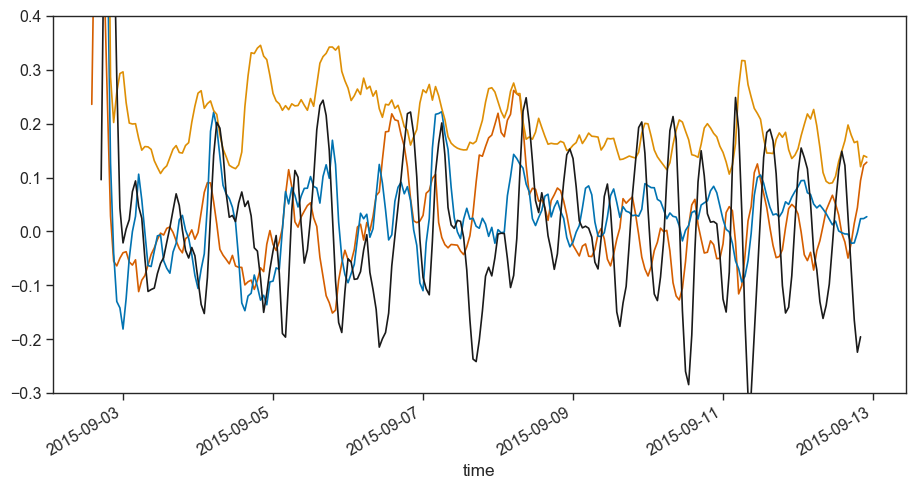

In [660]:
# dat.vort.mean('clusters').plot(color='r')
mvort.plot(color='r')
# dat.div.mean('clusters').plot(color='b')
mdiv.plot(color='b')
# dat.strain.mean('clusters').plot(color='C1')
mstrain.plot(color='C1')

deriv.pipe(lambda x: x/ff).rolling(time=4, center=True).mean().plot(color='k')

plt.ylim(-0.3,0.4)

In [664]:
dat['counts'] = np.isfinite(dat.mvort).sum(axis=0)

In [569]:
la, ua = get_ci(dat,'aspect')
ll, ul = get_ci(dat,'length')
ls, us = get_ci(dat,'strain')
lv, uv = get_ci(dat,'vort')
ld, ud = get_ci(dat,'div')

In [570]:
dat['la'] = ('time', la)
dat['ua'] = ('time', ua)
dat['ll'] = ('time', ll)
dat['ul'] = ('time', ul)
dat['ls'] = ('time', ls)
dat['us'] = ('time', us)
dat['lv'] = ('time', lv)
dat['uv'] = ('time', uv)
dat['ld'] = ('time', ld)
dat['ud'] = ('time', ud)

In [617]:
dat['mvort'] = mvort
dat['mdiv'] = mdiv
dat['mstrain'] = mstrain
dat['maspect'] = maspect
dat['mlength'] = mlength
dat['deriv'] = deriv

In [669]:
subset = dat[['counts','mvort','mdiv','mstrain','maspect','mlength',
             'la','ua','ll','ul','ls','us','lv','uv','ld','ud', 'deriv']]

In [670]:
subset.to_netcdf('../data/clusters/timeseries_plot1.nc')

In [671]:
dats = xr.open_dataset('../data/clusters/timeseries_plot1.nc')

In [692]:
pd.to_datetime('2015-09-04T4:00') 

Timestamp('2015-09-04 16:00:00')

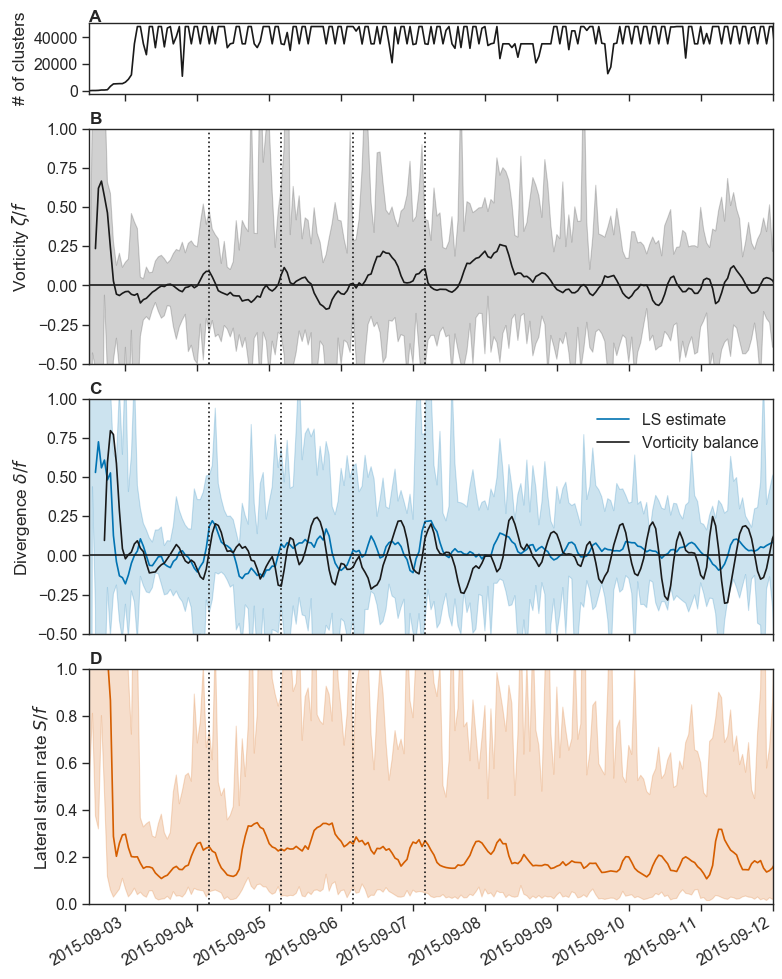

In [709]:
f = plt.figure(figsize=(8,10))
widths = [1]
heights = [0.3,1,1,1]
spec = f.add_gridspec(ncols=1,
                      nrows=4,
                      width_ratios=widths,
                      height_ratios=heights)

ax1 = f.add_subplot(spec[0, 0])
dats.counts.plot(ax=ax1, color='k')
ax1.set_xlabel(None)
ax1.set_ylabel(r'# of clusters')
ax1.set_yticks([0,20000,40000])
# ax1.set_yticklabels([r'$10^0$',r'$2\cdot 10^5$',r'$2\cdot 10^5$'])
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = f.add_subplot(spec[1, 0],sharex=ax1)
dat.mvort.plot(ax=ax2, color='k')
ax2.fill_between(dat.time.values,dats.lv,dats.uv,
                   alpha=0.2, color='k')
ax2.axhline(0,color='k')
ax2.set_ylabel(r'Vorticity $\zeta/f$')
ax2.set_xlabel(None)
ax2.set_ylim(-0.5,1)
plt.setp(ax2.get_xticklabels(), visible=False)

ax2.axvline(pd.to_datetime('2015-09-04T4:00'), color='k', ls='dotted')
ax2.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('24H'), color='k', ls='dotted')
ax2.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('48H'), color='k', ls='dotted')
ax2.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('72H'), color='k', ls='dotted')
        
ax3 = f.add_subplot(spec[2, 0],sharex=ax1)           
dats.mdiv.plot(ax=ax3, color='b', label='LS estimate')
dats.deriv.pipe(lambda x: x/ff).rolling(time=4, center=True).mean().plot(color='k', label='Vorticity balance')
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.set_xlabel(None)
ax3.fill_between(dat.time.values,dats.ld,dats.ud,
                   alpha=0.2, color='b')  
ax3.axhline(0,color='k')
ax3.set_ylim(-0.5,1)
ax3.set_ylabel(r'Divergence $\delta/f$')
plt.legend()

ax3.axvline(pd.to_datetime('2015-09-04T4:00'), color='k', ls='dotted')
ax3.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('24H'), color='k', ls='dotted')
ax3.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('48H'), color='k', ls='dotted')
ax3.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('72H'), color='k', ls='dotted')


ax4 = f.add_subplot(spec[3, 0],sharex=ax1)   
dat.mstrain.plot(ax=ax4, color='r')
ax4.fill_between(dat.time.values,dats.ls,dats.us,
                   alpha=0.2, color='r')
ax4.set_ylabel(r'Lateral strain rate $S/f$')
ax4.set_ylim(0,1)
ax4.set_xlabel(None)

ax4.set_xlim('2015-09-02T12:00:00','2015-09-12')

ax4.axvline(pd.to_datetime('2015-09-04T4:00'), color='k', ls='dotted')
ax4.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('24H'), color='k', ls='dotted')
ax4.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('48H'), color='k', ls='dotted')
ax4.axvline(pd.to_datetime('2015-09-04T4:00')+ pd.to_timedelta('72H'), color='k', ls='dotted')


alphabet([ax1,ax2,ax3,ax4])

spec.tight_layout(f)
spec.update(hspace=0.18)

plt.savefig('../figures/timeseries_v2.pdf')